# Capstone project: Classifying damaged vehicles for insurance verification
## Student: Durmishkhan Gigineishvili

### Please do not run all codes all together as you may no want to run optional part such as data preprocessing(1st part) , which is not necessary to reproduce as its for demonstration purposes primarily, not needed for model to work at all.

### Important PyTorch Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchvision.datasets import ImageFolder

### Torchvision - Image Handling and Preprocessing ; Pretrained Models:

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models

### Visualization and Analysis:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from collections import defaultdict

### Utility Libraries:

In [4]:
import zipfile
import os
import random
import shutil
import glob
import copy

### Google Colab-Related Libraries:

In [5]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Libraries I needed for Getting rid of Duplicates:

In [6]:
!pip install ImageHash
import imagehash
from PIL import Image, ImageOps
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 21.2 MB/s eta 0:00:00


In [7]:
torch.manual_seed(0) # This one for reproducibility

# First part: Data Preprocessing: (For Demonstration Purposes/Transparency)
 Importing initial raw dataset, please pay attention to note below!
<pre><em>
Note: Runing the codes in "First part" is optional, they are primarily for demonstration purposes, though you can check how they work and that's why I also provided with the necessary zip files I used in the repository and the initial dataset file link is available in README file.
</em></pre>

In [8]:
zip_path = '/content/drive/MyDrive/Initial_Dataset1.zip'#Importing the raw dataset from my google drive
extract_path = '/content/Initial_Dataset1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Initial dataset stats:


Total images in dataset: 5605


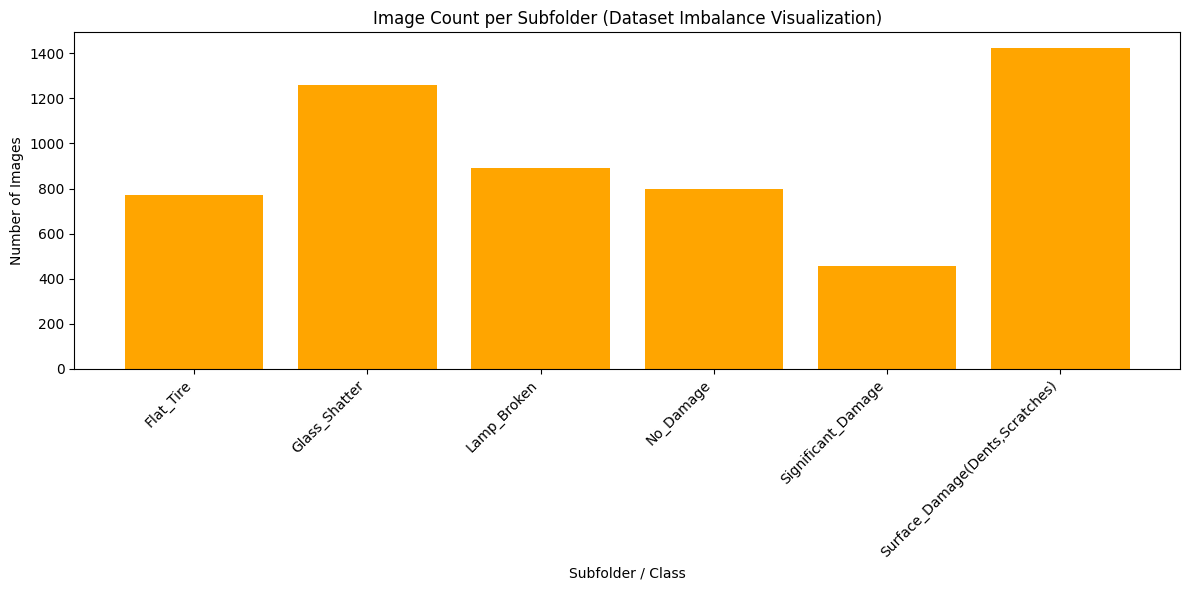

In [9]:
extract_path = '/content/Initial_Dataset1/Initial_Dataset1'
folder_names = []
image_counts = []
total_images = 0

for subfolder in sorted(os.listdir(extract_path)):
    subfolder_path = os.path.join(extract_path, subfolder)

    if os.path.isdir(subfolder_path):
        image_files = glob.glob(os.path.join(subfolder_path, '*.jpg')) + \
                      glob.glob(os.path.join(subfolder_path, '*.png')) + \
                      glob.glob(os.path.join(subfolder_path, '*.jpeg')) + \
                      glob.glob(os.path.join(subfolder_path, '*.JPEG'))

        count = len(image_files)
        folder_names.append(subfolder)
        image_counts.append(count)
        total_images += count

print(f"\nTotal images in dataset: {total_images}")

# Plotting bar chart
plt.figure(figsize=(12, 6))
plt.bar(folder_names, image_counts, color='orange')
plt.xlabel('Subfolder / Class')
plt.ylabel('Number of Images')
plt.title('Image Count per Subfolder (Dataset Imbalance Visualization)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Removing duplicates/mirrored/similar images from the initial dataset:


In [10]:
def remove_similar_duplicates(folder_path, hash_size=8, similarity_threshold=15): #similarity threshold 15 is quite high, it may delete some unique pictures too but I wanted to make sure there were no similar pictures
    hashes = []
    hash_paths = []
    folder_duplicate_count = defaultdict(int)
    total_duplicates = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".JPEG")):
                file_path = os.path.join(root, filename)
                try:
                    with Image.open(file_path) as img:
                        img_hash = imagehash.phash(img, hash_size=hash_size)
                        mirrored_hash = imagehash.phash(ImageOps.mirror(img), hash_size=hash_size)

                        is_duplicate = False
                        for existing_hash in hashes:
                            if (img_hash - existing_hash <= similarity_threshold) or \
                               (mirrored_hash - existing_hash <= similarity_threshold):
                                is_duplicate = True
                                break

                        if is_duplicate:
                            os.remove(file_path)
                            folder_name = os.path.basename(root)
                            folder_duplicate_count[folder_name] += 1
                            total_duplicates += 1
                        else:
                            hashes.append(img_hash)
                            hash_paths.append(file_path)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    # Summary output
    print("\nDuplicates removed per folder:")
    for folder, count in folder_duplicate_count.items():
        print(f"{folder}: {count} duplicate(s) removed")

    print(f"\nTotal duplicates removed: {total_duplicates}")

# Usage
folder = "/content/Initial_Dataset1"
remove_similar_duplicates(folder)


Duplicates removed per folder:
Surface_Damage(Dents,Scratches): 783 duplicate(s) removed
Glass_Shatter: 774 duplicate(s) removed
No_Damage: 394 duplicate(s) removed
Significant_Damage: 57 duplicate(s) removed
Flat_Tire: 492 duplicate(s) removed
Lamp_Broken: 453 duplicate(s) removed

Total duplicates removed: 2953


## Making archive for cleaned dataset:

In [11]:
shutil.make_archive('Cleaned_Initial_Dataset1', 'zip', '/content/Initial_Dataset1')

'/content/Cleaned_Initial_Dataset1.zip'

# Outputting per class distribution of the data after cleaning:


Total images in the cleaned raw dataset: 2652


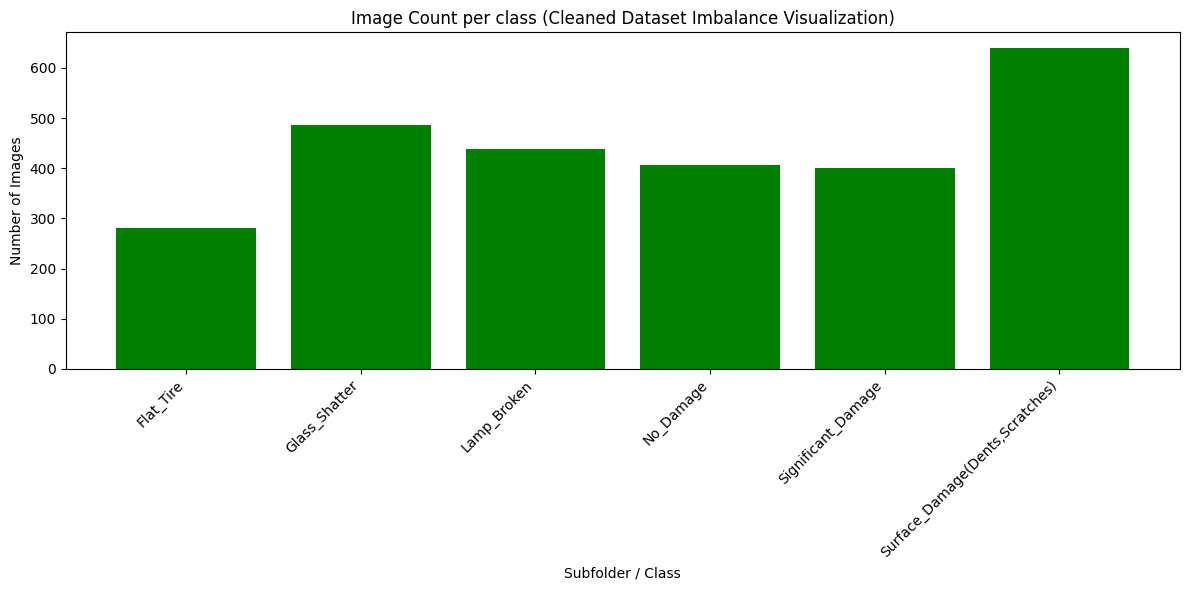

In [12]:
shutil.unpack_archive('Cleaned_Initial_Dataset1.zip', 'Cleaned_Initial_Dataset1')
cleaned_path = 'Cleaned_Initial_Dataset1'

extract_path = '/content/Cleaned_Initial_Dataset1/Initial_Dataset1'
folder_names = []
image_counts = []
total_images = 0

for subfolder in sorted(os.listdir(extract_path)):
    subfolder_path = os.path.join(extract_path, subfolder)

    if os.path.isdir(subfolder_path):
        image_files = glob.glob(os.path.join(subfolder_path, '*.jpg')) + \
                      glob.glob(os.path.join(subfolder_path, '*.png')) + \
                      glob.glob(os.path.join(subfolder_path, '*.jpeg')) + \
                      glob.glob(os.path.join(subfolder_path, '*.JPEG'))

        count = len(image_files)
        folder_names.append(subfolder)
        image_counts.append(count)
        total_images += count

print(f"\nTotal images in the cleaned raw dataset: {total_images}")

# Plotting bar chart
plt.figure(figsize=(12, 6))
plt.bar(folder_names, image_counts, color='green')
plt.xlabel('Subfolder / Class')
plt.ylabel('Number of Images')
plt.title('Image Count per class (Cleaned Dataset Imbalance Visualization)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Downloading the cleaned Dataset:

In [ ]:
files.download('Cleaned_Initial_Dataset1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### After I downloaded the Cleaned initial dataset I manually separated it to Train Validation and Test parts on my Laptop. I picked up 120-120 unique pictures for each class's validation and test sets and whatever was left was dedicated to training set. I also resized the images to 224x224 offline to save time while training.


### Upscaling train set to 700 images per class via some reasonable augmentation below:
 Note that this is done to only the train set not validation or test sets to be able to check how the model will truly generalize on unseen real world data. By upscaling all classes to 700 images I am balancing the train set enabling to capture more variablility and getting to final data distribution of 74.48% for train, 12.76-12.76% for val-test. Though in reality, in terms of unique pictures data distribution is following: 47% for training 26.5% for test and 26.5% for validation. That's due to trade off between having statistically significant amount for testing or validating and having images for training when data is scarce.

In [13]:
zip_path = '/content/drive/MyDrive/Train.zip' #Importing train set of my dataset to balance them across all classes
extract_path = '/content/Train_To_Be_Augmented'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [14]:
input_root  = '/content/Train_To_Be_Augmented/Train'
output_root = '/content/Augmented_Train'
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),#Mirroring the images
    transforms.RandomRotation(degrees=5),#Rotating images slightly left or right
    transforms.ColorJitter(brightness=0.1, contrast=0.15),#Modifying some light
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),# shifting image up or down, left or right slightly, degree 0 means that it wont be rotated
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),#Changing perspective we look at the image
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),# Adding sme blur as if picture was taken while movement
])

target_num = 700  # target number of images per class

for brand in os.listdir(input_root):
    src_dir = os.path.join(input_root, brand)
    dst_dir = os.path.join(output_root, brand)
    os.makedirs(dst_dir, exist_ok=True)

    originals = [f for f in os.listdir(src_dir) if f.lower().endswith(('jpg','png','jpeg'))]
    count_orig = len(originals)

    if count_orig == 0:
        print(f'Warning: No images found in {src_dir}, skipping augmentation.')
        continue  # skipping this class folder if empty

    # copy originals
    for fn in originals:
        img = Image.open(os.path.join(src_dir, fn)).convert('RGB')
        img = augmentation.transforms[0](img)  # resize only
        img.save(os.path.join(dst_dir, fn))

    aug_needed = target_num - count_orig
    if aug_needed <= 0:
        print(f'{brand} already has {count_orig} images, skipping augmentation.')
        continue

    # generating augmented images to reach target_num
    for i in range(aug_needed):
        fn = random.choice(originals)
        img = Image.open(os.path.join(src_dir, fn)).convert('RGB')
        aug_img = augmentation(img)
        aug_img.save(os.path.join(dst_dir, f'aug_{i}_{fn}'))

    print(f'{brand}: {count_orig} originals + {aug_needed} augmented → {len(os.listdir(dst_dir))} total')

Surface_Damage(Dents,Scratches): 313 originals + 387 augmented → 700 total
Glass_Shatter: 237 originals + 463 augmented → 700 total
No_Damage: 120 originals + 580 augmented → 700 total
Significant_Damage: 128 originals + 572 augmented → 700 total
Flat_Tire: 48 originals + 652 augmented → 700 total
Lamp_Broken: 185 originals + 515 augmented → 700 total


### Downloading Augmented Train Set and then manually adding it to cleaned dataset and finishing dataset preprocessing with that step:


In [ ]:
shutil.make_archive('Augmented_Train', 'zip', '/content/Augmented_Train')#Making a zip file of transformed train set
files.download('Augmented_Train.zip')# Downloading the file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Part 2 working with the CNN moddel:

## Code I used to delete saved models while experimenting:

In [ ]:
shutil.rmtree('/content/models', ignore_errors=True)  # deletes the entire folder
os.makedirs('/content/models', exist_ok=True)         # recreates an empty one
print("All models deleted.")

All models deleted.


## Defining the device that pytorch will use while training:

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')#Defining the device we 'll use while training
print(device)

cuda:0


## Loading the dataset:

In [16]:
zip_path = '/content/drive/MyDrive/Car_Damage_Classification_Capstone_224.zip' #Importing finally ready dataset for training
extract_path = '/content/Damage_Types'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Defining train, test, validation loaders, additional online train augmentation and outputting final stats of the data:

In [17]:
dataset_root="/content/Damage_Types/Car_Damage_Classification_Capstone_224"
train_transform = transforms.Compose([#I still add some online augmentation because dataset is relatively small in size, so I want to get as much variation as possible from it
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Defining the paths for each part of my data
train_dir = os.path.join(dataset_root, "Train")
val_dir   = os.path.join(dataset_root, "Validation")
test_dir  = os.path.join(dataset_root, "Test")

# Loading my splitted datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset  = ImageFolder(root=test_dir, transform=val_test_transform)

# Defining the data loaders I needed
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Printing the statistics of my data
print(" Dataset Summary:")
print(f"Train: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")
print(f"Classes: {train_dataset.classes}")

 Dataset Summary:
Train: 4200 images
Validation: 720 images
Test: 720 images
Classes: ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)']


## Outputting what images are in a random batch:

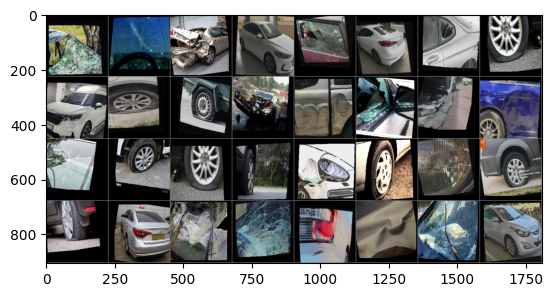

Lamp_Broken Lamp_Broken Surface_Damage(Dents,Scratches) Significant_Damage Lamp_Broken Significant_Damage Lamp_Broken Glass_Shatter Significant_Damage Glass_Shatter Glass_Shatter Surface_Damage(Dents,Scratches) Tire_Flat Lamp_Broken No_Damage Tire_Flat Lamp_Broken Glass_Shatter Glass_Shatter Glass_Shatter No_Damage Glass_Shatter No_Damage Glass_Shatter Glass_Shatter Significant_Damage Lamp_Broken Lamp_Broken No_Damage Tire_Flat Lamp_Broken Significant_Damage


In [18]:
# functions to show an image
classes=('Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)', 'Tire_Flat')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # expects images in [H, W, C]
    plt.show()


# get some random training images
dataiter = iter(train_loader) # This converts the trainloader into an iterator
images, labels = next(dataiter) # next batch from a Python iterator

# show images
imshow(torchvision.utils.make_grid(images))  # stitches a batch of images into a single image grid
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

## To have better idea what classes generally look like I'll output one random image from each class:


Detected classes (6): ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)']
Example indices chosen: [0, 700, 1400, 2100, 2800, 3500]


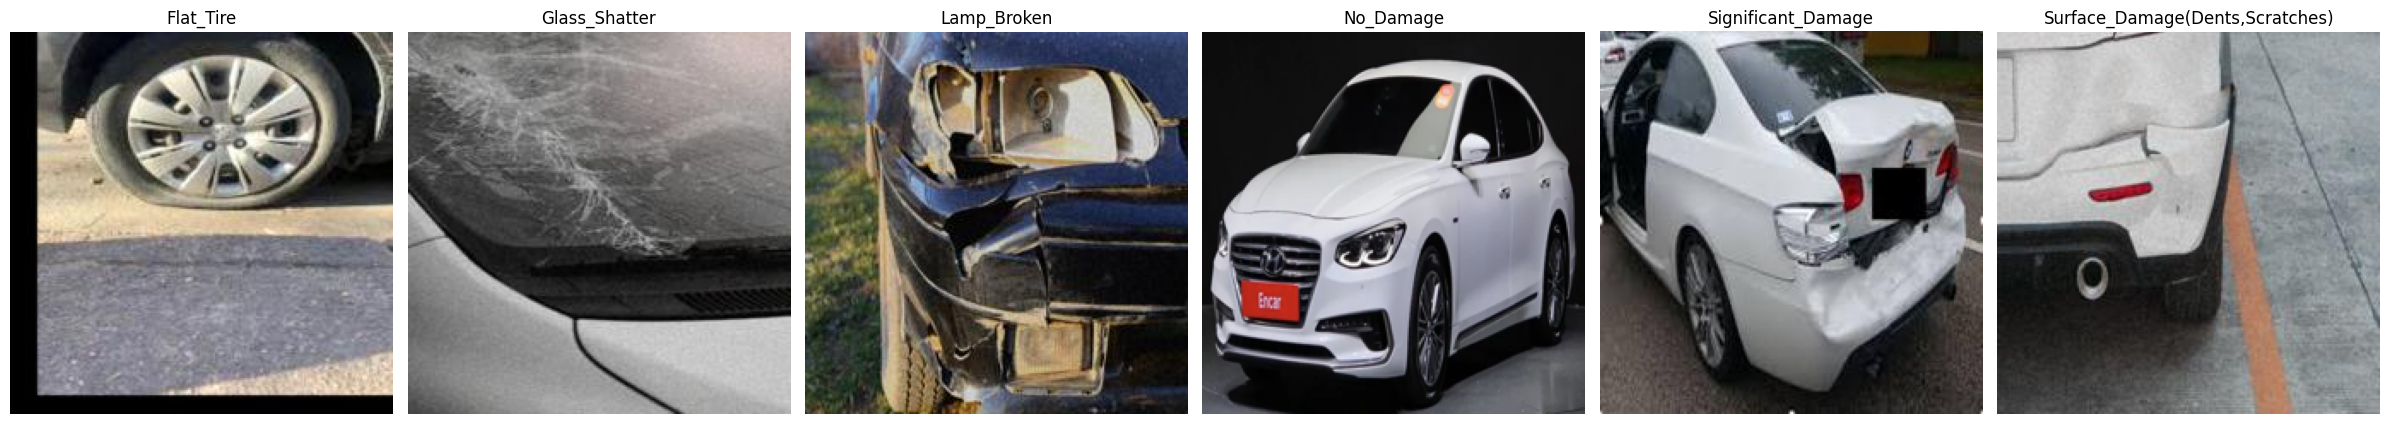

In [19]:
dataset_path = '/content/Damage_Types/Car_Damage_Classification_Capstone_224/Train'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

print(f"Detected classes ({num_classes}): {class_names}")

example_indices = []
for class_idx in range(num_classes):
    found = False
    for i, (_, label) in enumerate(dataset.imgs):
        if label == class_idx:
            example_indices.append(i)
            found = True
            break
    if not found:
        print(f"No images found for class {class_names[class_idx]}")

print(f"Example indices chosen: {example_indices}")

fig, axs = plt.subplots(1, num_classes, figsize=(4*num_classes, 5))

for i, idx in enumerate(example_indices):
    img, label = dataset[idx]
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
    axs[i].imshow(img)
    axs[i].set_title(class_names[label])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Defining the Scratch CNN model I created:

In [20]:
class MyCNN(nn.Module): #Defininf my 6 layered convolution neural network
    def __init__(self, num_classes=6):
        super(MyCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(2048, 1048),
            nn.BatchNorm1d(1048),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1048,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),


            nn.Linear(512, 6)
        )

    def forward(self, x): #The function which will send the data through the NN
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## The training Loop: (~15 minutes to train with colab free version)

Epoch [1] - Total Loss: 162.1267, Average Loss: 1.2282
> Validation Accuracy: 63.33%
✔️ Validation improved — model saved.
 📉 Current Learning Rate: 0.002000
Epoch [2] - Total Loss: 109.4910, Average Loss: 0.8295
> Validation Accuracy: 57.36%
 ⚠️ No improvement (1/5)
 📉 Current Learning Rate: 0.002000
Epoch [3] - Total Loss: 92.1524, Average Loss: 0.6981
> Validation Accuracy: 65.42%
✔️ Validation improved — model saved.
 📉 Current Learning Rate: 0.002000
Epoch [4] - Total Loss: 80.0978, Average Loss: 0.6068
> Validation Accuracy: 50.00%
 ⚠️ No improvement (1/5)
 📉 Current Learning Rate: 0.002000
Epoch [5] - Total Loss: 75.9008, Average Loss: 0.5750
> Validation Accuracy: 72.08%
✔️ Validation improved — model saved.
 📉 Current Learning Rate: 0.002000
Epoch [6] - Total Loss: 64.2137, Average Loss: 0.4865
> Validation Accuracy: 75.97%
✔️ Validation improved — model saved.
 📉 Current Learning Rate: 0.002000
Epoch [7] - Total Loss: 59.2110, Average Loss: 0.4486
> Validation Accuracy: 79.72

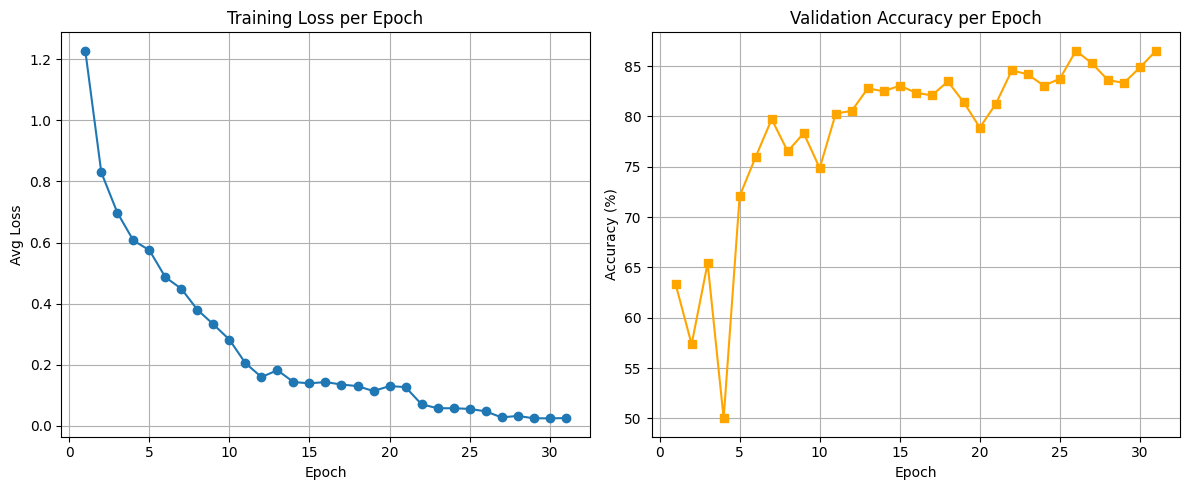

In [21]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
epoch_losses = []
val_accuracies = []

best_val_acc = 0.0
epochs_without_improvement = 0
patience = 5  # My training loop will stop after 5 bad epochs

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Here I'm defining my ReduceLROnPlateau scheduler which helps me to avoid decreasing the global LR agressivly, too early or too late
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2 # After 2 bad epochs my global LR will be multiplied by factor and become less to help find better local minima
)

for epoch in range(50):#Mximum epochs I am going to train the loop
    running_loss = 0.0
    total_batches = 0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_batches += 1

    avg_loss = running_loss / total_batches
    epoch_losses.append(avg_loss)
    print(f'Epoch [{epoch + 1}] - Total Loss: {running_loss:.4f}, Average Loss: {avg_loss:.4f}')

    # Validation Part of the loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f'> Validation Accuracy: {val_acc * 100:.2f}%')

    # Defining early stopping condition: So if improvement is less than 0.001 or 0.1% then it will consider as no improvement
    if val_acc > best_val_acc + 0.001:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("✔️ Validation improved — model saved.")
    else:
        epochs_without_improvement += 1
        print(f' ⚠️ No improvement ({epochs_without_improvement}/{patience})')

        if epochs_without_improvement >= patience:
            print(" 🛑 Early stopping was triggered.")
            break

    # Step: update LR based on validation accuracy
    scheduler.step(val_acc)
    print(f" 📉 Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

print('✅ Finished Training')

# Plotting loss and accuracy graphs per epoch
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, len(val_accuracies) + 1), [v*100 for v in val_accuracies], marker='s', color='orange')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Loading my model:

In [22]:
model.load_state_dict(torch.load('best_model.pth')) #Getting my Best model which was saved during the training loop
model.to(device)
model.eval()

MyCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Testing my model on test set:

In [23]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f" Final Test Accuracy: {test_acc * 100:.2f}%")

 Final Test Accuracy: 84.72%


# Part 3, Error analysis:
Checking the per class accuracy of my model:

In [24]:
model.eval()

# Initialize counters
class_correct = defaultdict(int)
class_total   = defaultdict(int)


classes = test_dataset.classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Print accuracy per class
print("\n Per-Class Accuracy:")
for i, class_name in enumerate(classes):
    correct = class_correct[i]
    total = class_total[i]
    acc = 100.0 * correct / total if total > 0 else 0.0
    print(f"{class_name:<15}: {correct}/{total} -> {acc:.2f}%")


 Per-Class Accuracy:
Flat_Tire      : 96/120 -> 80.00%
Glass_Shatter  : 101/120 -> 84.17%
Lamp_Broken    : 98/120 -> 81.67%
No_Damage      : 106/120 -> 88.33%
Significant_Damage: 106/120 -> 88.33%
Surface_Damage(Dents,Scratches): 103/120 -> 85.83%


## For Better Visualization of Per Class Accuracy:

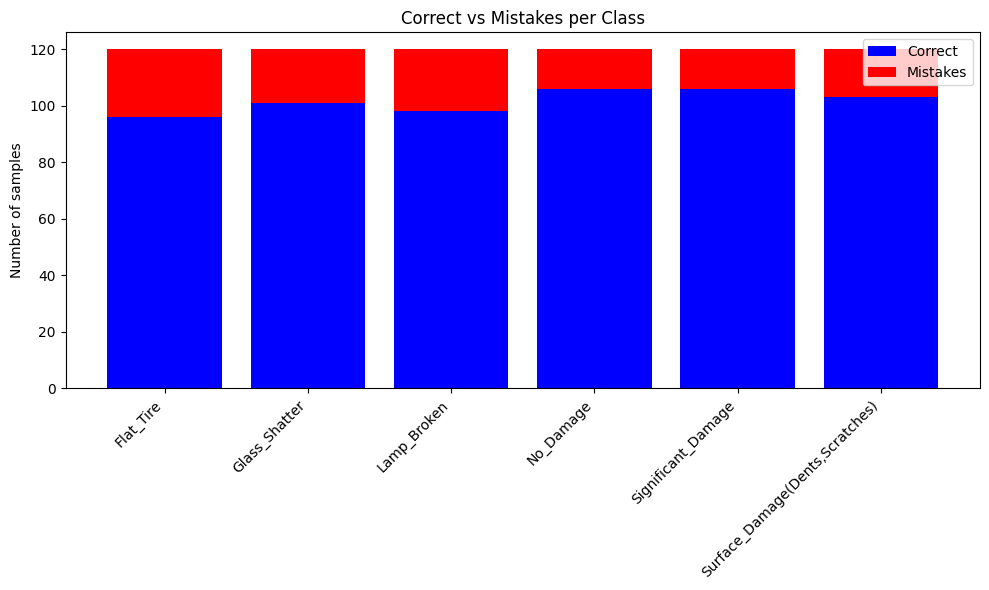

In [25]:
classes = test_dataset.classes

correct_counts = []
error_counts = []

for i in range(len(classes)):
    correct = class_correct[i]
    total = class_total[i]
    errors = total - correct
    correct_counts.append(correct)
    error_counts.append(errors)

x = np.arange(len(classes))

plt.figure(figsize=(10,6))
plt.bar(x, correct_counts, label='Correct', color='b')
plt.bar(x, error_counts, bottom=correct_counts, label='Mistakes', color='r')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel('Number of samples')
plt.title('Correct vs Mistakes per Class')
plt.legend()
plt.tight_layout()
plt.show()

## Let's see the confusion matrix to have better understanding why model performed weakly especially in some classes:

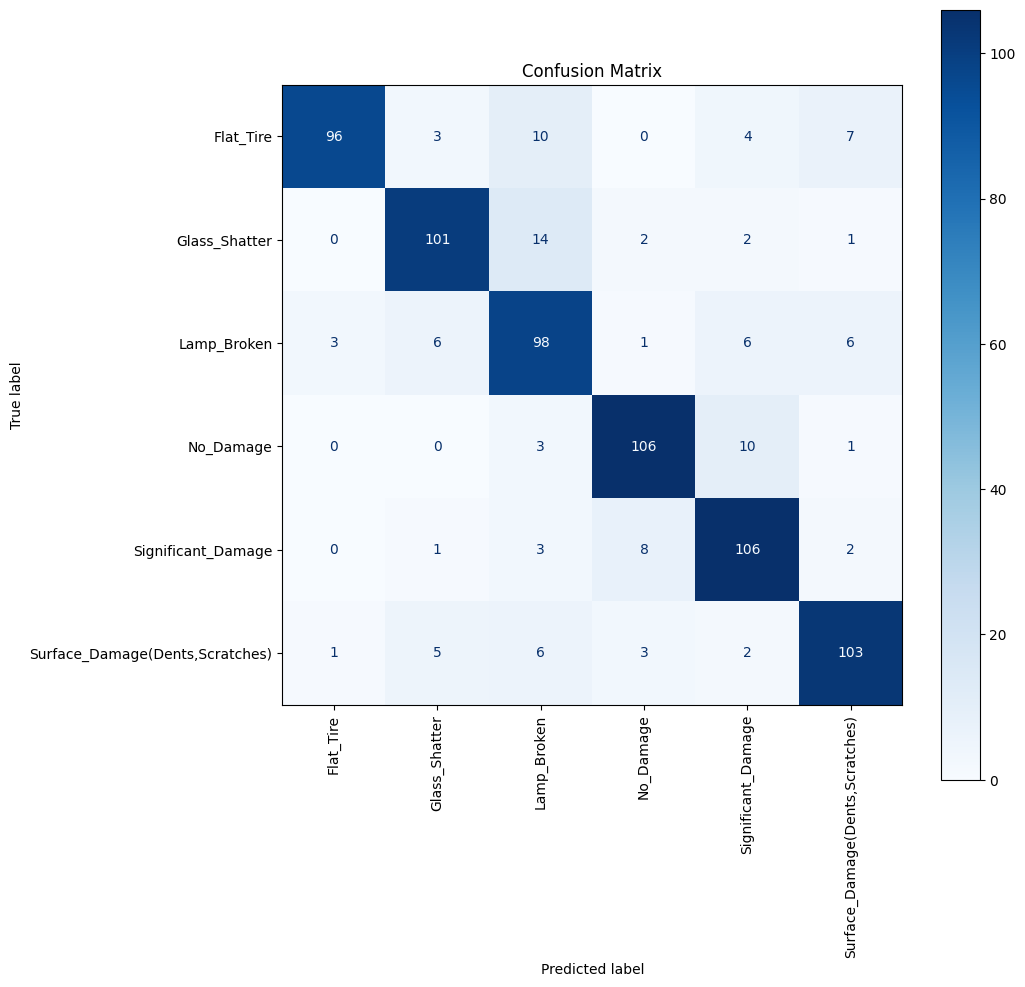

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: Class names (replace with your actual class names)
class_names = ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage','Surface_Damage(Dents,Scratches)']
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

## Now let us take one more step forward: Let's train the model on residuals to see whether we can or cannot increase model accuracy:

In [27]:
model.eval()  # Freeze main model

# Define the residual model
residual_model = MyCNN().to(device)

# Optimizer and loss function
optimizer_residual = torch.optim.Adam(residual_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 3

for epoch in range(num_epochs):
    residual_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get predictions from main model (no gradients)
        with torch.no_grad():
            main_logits = model(inputs)
            main_probs = torch.softmax(main_logits, dim=1)

        # One-hot encode labels
        labels_one_hot = F.one_hot(labels, num_classes=6).float().to(device)

        # Compute residuals
        residual_targets = labels_one_hot - main_probs

        # Predict residuals
        optimizer_residual.zero_grad()
        residual_output = residual_model(inputs)  # Raw output, no softmax

        # Compute loss
        loss = criterion(residual_output, residual_targets)
        loss.backward()
        optimizer_residual.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Residual Training Loss: {avg_loss:.4f}")

    # Validation
    residual_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            main_logits = model(inputs)
            main_probs = torch.softmax(main_logits, dim=1)
            labels_one_hot = F.one_hot(labels, num_classes=6).float().to(device)
            residual_targets = labels_one_hot - main_probs

            residual_output = residual_model(inputs)
            loss = criterion(residual_output, residual_targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Residual Validation Loss: {avg_val_loss:.4f}")

Epoch [1/3] Residual Training Loss: 0.0689
Epoch [1/3] Residual Validation Loss: 0.0636
Epoch [2/3] Residual Training Loss: 0.0217
Epoch [2/3] Residual Validation Loss: 0.0401
Epoch [3/3] Residual Training Loss: 0.0104
Epoch [3/3] Residual Validation Loss: 0.0381


## Combining test accuracy with residual training results:

In [28]:
def evaluate_combined_or_base(model, residual_model, test_loader, device):


    model.eval()
    residual_model.eval()

    base_preds, base_labels = [], []
    residual_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Base model prediction
            base_logits = model(inputs)
            base_probs = torch.softmax(base_logits, dim=1)
            base_pred = base_probs.argmax(dim=1)

            # Residual model prediction
            residual_output = residual_model(inputs)

            # Ensure shapes match before adding
            if residual_output.shape != base_probs.shape:
                raise ValueError(f"Shape mismatch: base_probs {base_probs.shape}, residual_output {residual_output.shape}")

            combined_logits = base_probs + residual_output
            combined_probs = torch.softmax(combined_logits, dim=1)
            combined_pred = combined_probs.argmax(dim=1)

            base_preds.append(base_pred.cpu())
            residual_preds.append(combined_pred.cpu())
            base_labels.append(labels.cpu())

    # Concatenate
    base_preds = torch.cat(base_preds)
    residual_preds = torch.cat(residual_preds)
    base_labels = torch.cat(base_labels)

    # Accuracies
    base_acc = (base_preds == base_labels).float().mean().item()
    residual_acc = (residual_preds == base_labels).float().mean().item()

    print(f"Pretrained Model Accuracy: {base_acc * 100:.2f}%")
    print(f"Combined Model Accuracy after Residual Training: {residual_acc * 100:.2f}%")

    if residual_acc > base_acc:
        print("✅ Residual training improved performance. Using combined model.")
        return residual_preds, base_labels, residual_acc
    else:
        print("⚠️ No improvement after residual training. Using original model predictions.")
        return base_preds, base_labels, base_acc


# ✅ Call the function to actually run it
all_preds, all_labels, final_accuracy = evaluate_combined_or_base(model, residual_model, test_loader, device)

Pretrained Model Accuracy: 84.72%
Combined Model Accuracy after Residual Training: 84.58%
⚠️ No improvement after residual training. Using original model predictions.


## Acknowledging that the test set is not whole population it's reasonable to develope a rough, approximated 95% confidence interval approximated by bootstrapped sampling:

In [29]:
all_preds_np = all_preds.cpu().numpy() if torch.is_tensor(all_preds) else all_preds
all_labels_np = all_labels.cpu().numpy() if torch.is_tensor(all_labels) else all_labels

n = len(all_labels_np)
n_bootstraps = 100000
bootstrapped_accuracies = []

for _ in range(n_bootstraps):
    indices = np.random.choice(n, size=n, replace=True)  # sample with replacement
    sample_preds = all_preds_np[indices]
    sample_labels = all_labels_np[indices]
    acc = np.mean(sample_preds == sample_labels)
    bootstrapped_accuracies.append(acc)

bootstrapped_accuracies = np.array(bootstrapped_accuracies)
lower = np.percentile(bootstrapped_accuracies, 2.5)
upper = np.percentile(bootstrapped_accuracies, 97.5)
mean_acc = np.mean(bootstrapped_accuracies)

print(f"Bootstrap mean accuracy: {mean_acc * 100:.2f}%")
print(f"95% Confidence Interval (Bootstrap): [{lower * 100:.2f}%, {upper * 100:.2f}%]")

Bootstrap mean accuracy: 84.71%
95% Confidence Interval (Bootstrap): [82.08%, 87.36%]


## Plotting how bootstraped accuracy distribution looks like:

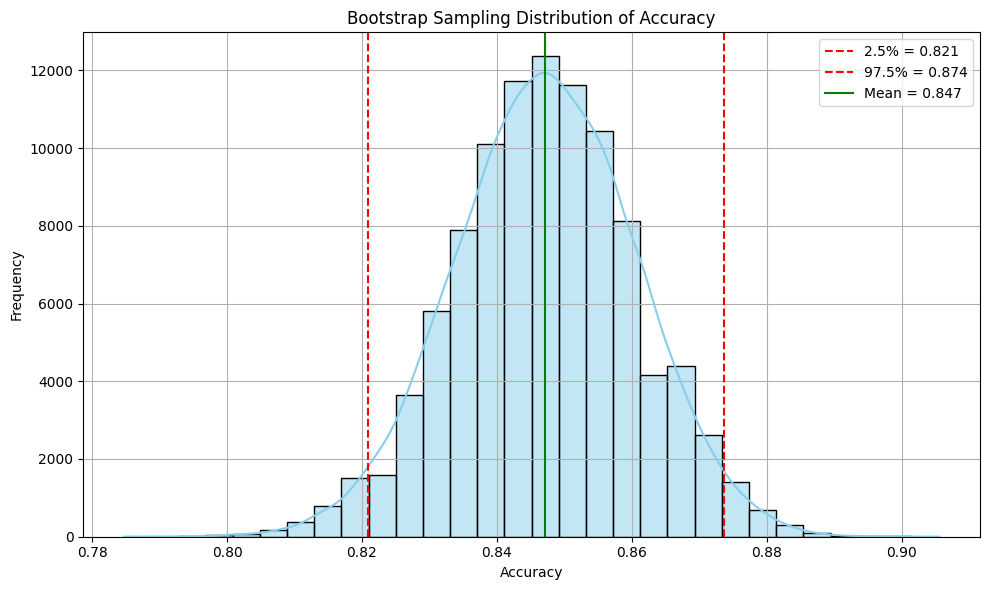

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrapped_accuracies, bins=30, kde=True, color="skyblue")

# Plot the confidence interval lines
plt.axvline(lower, color='red', linestyle='--', label=f'2.5% = {lower:.3f}')
plt.axvline(upper, color='red', linestyle='--', label=f'97.5% = {upper:.3f}')
plt.axvline(mean_acc, color='green', linestyle='-', label=f'Mean = {mean_acc:.3f}')

plt.title('Bootstrap Sampling Distribution of Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Confidence intervals for per class accuracies: (Using binomial distribution)

In [31]:
model.eval()

# Initialize counters
class_correct = defaultdict(int)
class_total   = defaultdict(int)

classes = test_dataset.classes
z = norm.ppf(0.975)  # 95% CI z-score ≈ 1.96

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Print accuracy and 95% CI per class
print("\nPer-Class Accuracy with 95% Confidence Intervals:\n" + "-" * 60)
for i, class_name in enumerate(classes):
    correct = class_correct[i]
    total = class_total[i]

    if total == 0:
        print(f"{class_name:<15}: ❌ No samples")
        continue

    acc = correct / total
    se = math.sqrt((acc * (1 - acc)) / total)
    lower = max(0.0, acc - z * se)
    upper = min(1.0, acc + z * se)

    print(f"{class_name:<15}: {correct}/{total} -> "
          f"{acc * 100:.2f}%  (95% CI: [{lower * 100:.2f}%, {upper * 100:.2f}%])")


Per-Class Accuracy with 95% Confidence Intervals:
------------------------------------------------------------
Flat_Tire      : 96/120 -> 80.00%  (95% CI: [72.84%, 87.16%])
Glass_Shatter  : 101/120 -> 84.17%  (95% CI: [77.64%, 90.70%])
Lamp_Broken    : 98/120 -> 81.67%  (95% CI: [74.74%, 88.59%])
No_Damage      : 106/120 -> 88.33%  (95% CI: [82.59%, 94.08%])
Significant_Damage: 106/120 -> 88.33%  (95% CI: [82.59%, 94.08%])
Surface_Damage(Dents,Scratches): 103/120 -> 85.83%  (95% CI: [79.59%, 92.07%])


# Part 4, Testing on some different real world picture:
 Testing my model on unseen external picture and makiing it to predict:

### Code below is for loading my best model without need of training as it's saved to get prediction on external image input:

In [32]:
model = MyCNN()  # or model = models.resnet50(pretrained=False) for ResNet

# Load saved weights
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()  # set to eval mode before inference

MyCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Uploading the picture:

In [43]:
uploaded = files.upload() #Uploading a picture I want my model to predict what it is

Saving significant_damage3.jpg to significant_damage3.jpg


## Making model predict what type of  damage is depicted in the uploaded picture:
### Note if model is 100% sure that class is a certain class it either had high accuracy overall or it has seen that picture in the training set no matter strength of the model.
### The distribution of probabilities also shows what kind of damages did the model notice in the picture which makes these classification problem in characteristics similar to  image detection problem in some sense.


Predicted Class: Significant_Damage
Class Probabilities:
  Flat_Tire: 0.03%
  Glass_Shatter: 0.99%
  Lamp_Broken: 0.17%
  No_Damage: 0.00%
  Significant_Damage: 98.81%
  Surface_Damage(Dents,Scratches): 0.00%


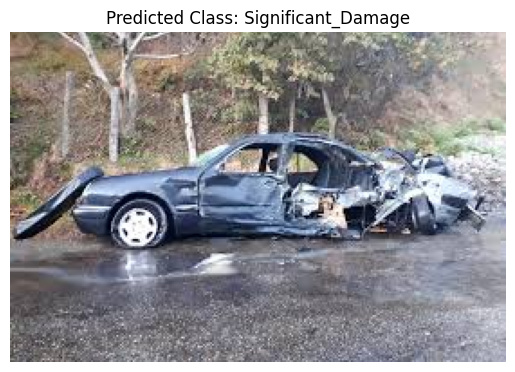

In [ ]:
Classes = ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)']

# Map index to class name
idx_to_class = {i: c for i, c in enumerate(Classes)}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prediction transform (should match training preprocessing)
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load image
image_path = "External_Test_Picture.jpg"  # replace with your image path
img = Image.open(image_path).convert("RGB")
img_tensor = predict_transform(img).unsqueeze(0).to(device)  # add batch dimension

# Load model
# model = MyCustomModel()
# model.load_state_dict(torch.load("model.pth"))
# model.to(device)
# model.eval()

# Prediction
with torch.no_grad():
    output = model(img_tensor)  # raw logits
    probs = F.softmax(output, dim=1).cpu().numpy().flatten()

predicted_class_idx = probs.argmax()
predicted_label = idx_to_class[predicted_class_idx]

print(f"Predicted Class: {predicted_label}")
print("Class Probabilities:")
for i, class_name in idx_to_class.items():
    print(f"  {class_name}: {probs[i]*100:.2f}%")

# Show image with predicted label as title
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}")
plt.show()

# Part 5: The final upgrade:
#Training on a pretrained model , Resnet50

### Code I used to delete pretrained saved model while experimenting:

In [49]:
file_path = 'best_pretrained_model.pth'

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")

best_pretrained_model.pth does not exist.


## Defining the pretrained model I use, early stopping, train/validation functions:

In [50]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#Deinfing train and validation loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# The model setup
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # HERE IS THE CODE WHERE RESNET IS DEFINED
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 6)
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Resnet_model = model.to(device)
criterion = nn.CrossEntropyLoss()

#Defining Training And Validation Functions:
def train_epoch(model, loader, criterion, optimizer):
    Resnet_model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = Resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def validate_epoch(Resnet_model, loader, criterion):
    Resnet_model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = Resnet_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


## The training loop using pretrained resnet50: (~15 minutes with google colab free GPU)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training head only...
[Head] Epoch 1: Train Loss=1.4921, Acc=0.5481 | Val Loss=1.2621, Acc=0.6792
  ✅ Best model updated.
[Head] Epoch 2: Train Loss=1.0512, Acc=0.7990 | Val Loss=0.9904, Acc=0.7222
  ✅ Best model updated.
[Head] Epoch 3: Train Loss=0.8271, Acc=0.8267 | Val Loss=0.8623, Acc=0.7431
  ✅ Best model updated.
[Head] Epoch 4: Train Loss=0.7078, Acc=0.8424 | Val Loss=0.7468, Acc=0.7583
  ✅ Best model updated.
[Head] Epoch 5: Train Loss=0.6231, Acc=0.8512 | Val Loss=0.6908, Acc=0.7847
  ✅ Best model updated.
Unfreezing last conv block (layer4) + FC layer...
[Last_layers] Epoch 1: Train Loss=0.2099, Acc=0.9331 | Val Loss=0.4089, Acc=0.8806
  ✅ Best model updated.
[Last_layers] Epoch 2: Train Loss=0.0933, Acc=0.9717 | Val Loss=0.4859, Acc=0.8806
[Last_layers] Epoch 3: Train Loss=0.0555, Acc=0.9831 | Val Loss=0.4180, Acc=0.8944
[Last_layers] Epoch 4: Train Loss=0.0465, Acc=0.9855 | Val Loss=0.3327, Acc=0.9097
  ✅ Best model updated.
[Last_layers] Epoch 5: Train Loss=0.0412, Acc=0.

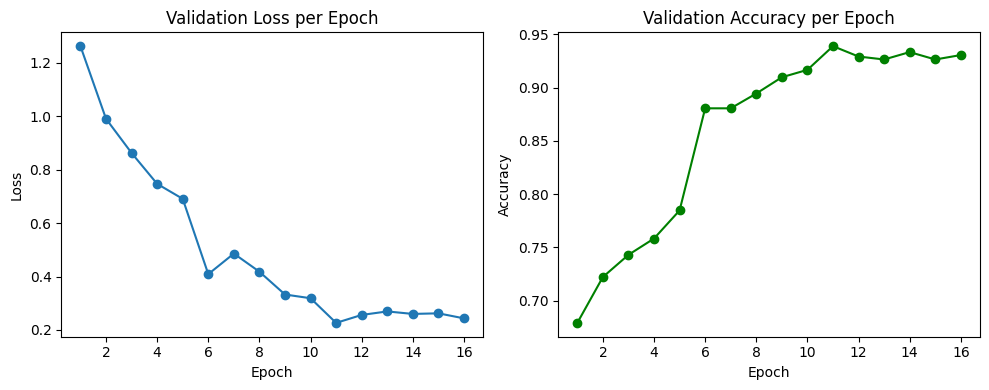

In [51]:

all_val_losses, all_val_accs = [], []

# Training phase function with best model saving per phase
def train_phase(description, num_epochs, optimizer, scheduler, early_stopping):
    global best_model_wts, best_val_loss

    # Reset best validation loss and weights at the start of this phase
    best_val_loss = float("inf")
    best_model_wts = copy.deepcopy(Resnet_model.state_dict())

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(Resnet_model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate_epoch(Resnet_model, val_loader, criterion)

        print(f"[{description}] Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        all_val_losses.append(val_loss)
        all_val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(Resnet_model.state_dict())
            print("  ✅ Best model updated.")
            torch.save(best_model_wts, f"best_model_{description.replace(' ', '_')}.pth")

        scheduler.step(val_loss)
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"  🛑 Early stopping triggered in {description}.")
            break

# First part of pretrained model using training FC head only
optimizer = optim.Adam(Resnet_model.fc.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=4)
print("Training head only...")
train_phase("Head", 5, optimizer, scheduler, early_stopping)

# 2nd part of training loop unfreezing last convolutional block + FC layer
for name, param in Resnet_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, Resnet_model.parameters()), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=4)
print("Unfreezing last conv block (layer4) + FC layer...")
train_phase("Last_layers", 5, optimizer, scheduler, early_stopping)

# 3rd and last part of training fully unfreezing pretrained model for fine tuning
for param in Resnet_model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(Resnet_model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=5)
print("Fully unfreezing the model for fine-tuning...")
train_phase("Fine_tune_all", 10, optimizer, scheduler, early_stopping)

# Loading the best weights from the last phase and save the final model
Resnet_model.load_state_dict(best_model_wts)
torch.save(Resnet_model.state_dict(), "best_pretrained_model.pth")
print("Best model saved as 'best_pretrained_model.pth'.")

# Plotting validation loss and accuracy containing all 3 parts of using pretrained resnet
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(range(1, len(all_val_losses)+1), all_val_losses, marker='o')
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(all_val_accs)+1), all_val_accs, marker='o', color='green')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

## Defining code for testing the pretrained model on the test data:

In [52]:
def test_pretrained_model(model, loader, criterion):
    Resnet_model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = Resnet_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## Loading trained best resnet model:

In [53]:
Resnet_model.load_state_dict(torch.load('best_pretrained_model.pth'))
Resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Testing the ResNet50 pretrained model:

In [54]:
test_loss, test_acc = test_pretrained_model(Resnet_model, test_loader, criterion)
print(f"Test Accuracy of the pretrained model: {test_acc * 100:.2f}%")

Test Accuracy of the pretrained model: 94.03%


## Developing approximated 95% confidence interval using bootstrapped method:

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32  # or whatever you prefer

# Step 1: Get predictions and labels once
def get_preds_and_labels(Resnet_model, dataset, batch_size=batch_size):
    Resnet_model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    preds_list, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = Resnet_model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.array(preds_list), np.array(labels_list)

# Step 2: Fast bootstrap on cached preds and labels
def fast_bootstrap_accuracy(preds, labels, n_bootstraps=1000):
    n = len(labels)
    accs = []

    for _ in range(n_bootstraps):
        idxs = np.random.choice(n, size=n, replace=True)
        acc = np.mean(preds[idxs] == labels[idxs])
        accs.append(acc)

    lower = np.percentile(accs, 2.5)
    upper = np.percentile(accs, 97.5)
    return lower, upper, np.mean(accs)

# Example usage:
preds, labels = get_preds_and_labels(Resnet_model, test_dataset, batch_size=batch_size)
lower, upper, mean_acc = fast_bootstrap_accuracy(preds, labels, n_bootstraps=1000)
print(f"Bootstrap Mean Accuracy: {mean_acc * 100:.2f}%")
print(f"95% Confidence Interval: ({lower * 100:.2f}%, {upper * 100:.2f}%)")

Bootstrap Mean Accuracy: 94.00%
95% Confidence Interval: (92.22%, 95.69%)


# Now let's see and compare in what ways did the pretrained model improved the accuracies:

In [56]:
Resnet_model.eval()

# Initialize counters
class_correct = defaultdict(int)
class_total   = defaultdict(int)

classes = test_dataset.classes

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = Resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Print accuracy per class
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(classes):
    correct = class_correct[i]
    total = class_total[i]
    acc = 100.0 * correct / total if total > 0 else 0.0
    print(f"{class_name:<15}: {correct}/{total} -> {acc:.2f}%")


Per-Class Accuracy:
Flat_Tire      : 112/120 -> 93.33%
Glass_Shatter  : 113/120 -> 94.17%
Lamp_Broken    : 113/120 -> 94.17%
No_Damage      : 116/120 -> 96.67%
Significant_Damage: 114/120 -> 95.00%
Surface_Damage(Dents,Scratches): 109/120 -> 90.83%


## Developing 95% confidence intervals for per class accuracies (With binomial distribution):

In [57]:
Resnet_model.eval()

# Initialize counters
class_correct = defaultdict(int)
class_total   = defaultdict(int)

classes = test_dataset.classes
z = norm.ppf(0.975)  # 95% CI z-score ≈ 1.96

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = Resnet_model(inputs)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Print accuracy and 95% CI per class
print("\nPer-Class Accuracy with 95% Confidence Intervals:\n" + "-" * 60)
for i, class_name in enumerate(classes):
    correct = class_correct[i]
    total = class_total[i]

    if total == 0:
        print(f"{class_name:<15}: ❌ No samples")
        continue

    acc = correct / total
    se = math.sqrt((acc * (1 - acc)) / total)
    lower = max(0.0, acc - z * se)
    upper = min(1.0, acc + z * se)

    print(f"{class_name:<15}: {correct}/{total} -> "
          f"{acc * 100:.2f}%  (95% CI: [{lower * 100:.2f}%, {upper * 100:.2f}%])")


Per-Class Accuracy with 95% Confidence Intervals:
------------------------------------------------------------
Flat_Tire      : 112/120 -> 93.33%  (95% CI: [88.87%, 97.80%])
Glass_Shatter  : 113/120 -> 94.17%  (95% CI: [89.97%, 98.36%])
Lamp_Broken    : 113/120 -> 94.17%  (95% CI: [89.97%, 98.36%])
No_Damage      : 116/120 -> 96.67%  (95% CI: [93.45%, 99.88%])
Significant_Damage: 114/120 -> 95.00%  (95% CI: [91.10%, 98.90%])
Surface_Damage(Dents,Scratches): 109/120 -> 90.83%  (95% CI: [85.67%, 96.00%])


## Now lets check the confusion matrix:

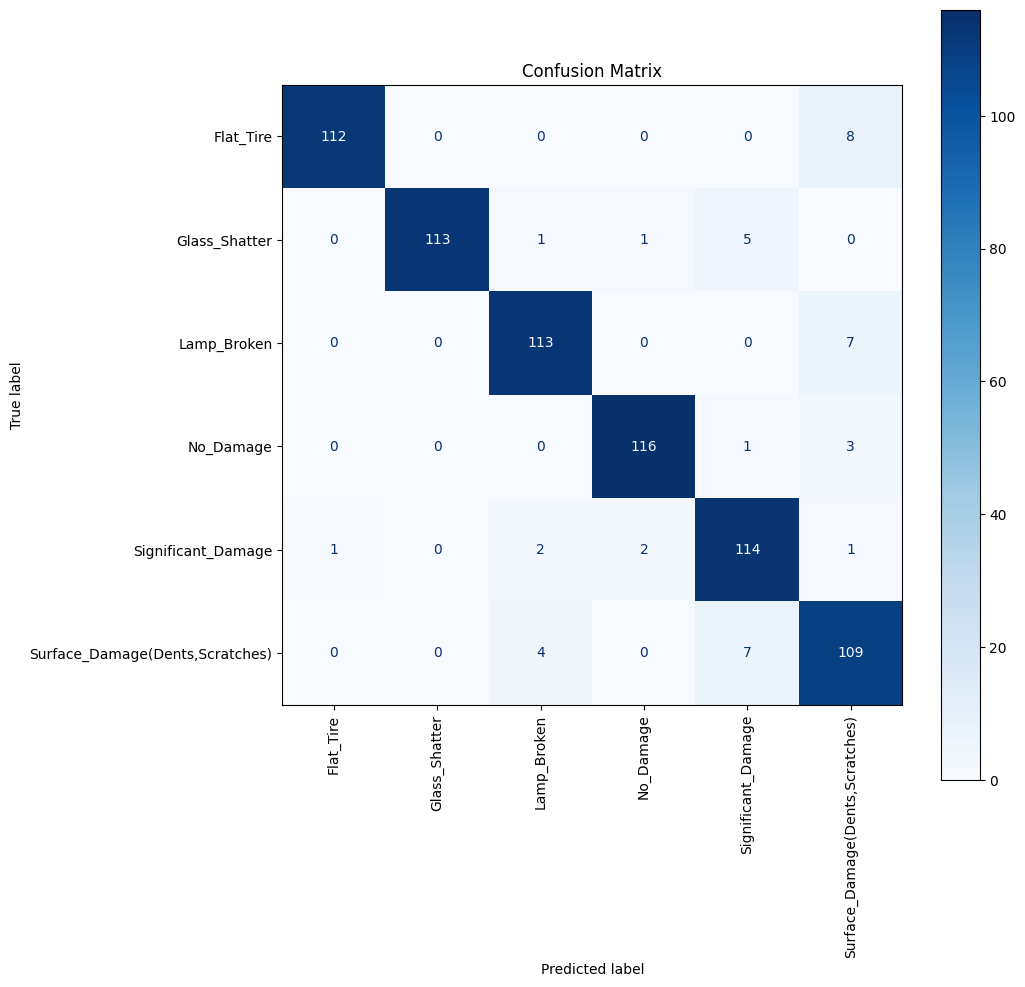

In [58]:
Resnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = Resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Class names (update if needed)
class_names = ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

## Add picture to test it using transfer learning model

In [ ]:
uploaded = files.upload() #Uploading a picture I want my model to predict what it is

## Test the model on picture

Predicted Class: Significant_Damage
Class Probabilities:
  Flat_Tire: 0.00%
  Glass_Shatter: 0.00%
  Lamp_Broken: 0.00%
  No_Damage: 0.00%
  Significant_Damage: 100.00%
  Surface_Damage(Dents,Scratches): 0.00%


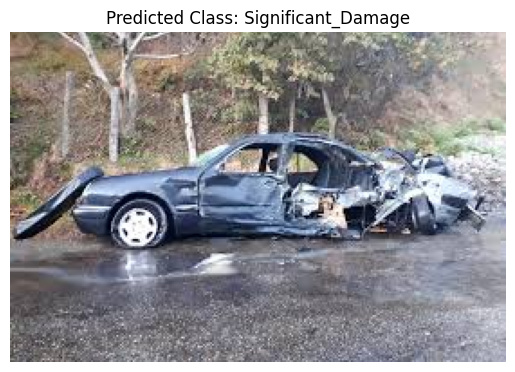

In [ ]:
Resnet_model.eval()

# Class labels
Classes = ['Flat_Tire', 'Glass_Shatter', 'Lamp_Broken', 'No_Damage', 'Significant_Damage', 'Surface_Damage(Dents,Scratches)']
idx_to_class = {i: c for i, c in enumerate(Classes)}

# Set device (already done, but for safety)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transform — must match training
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load and preprocess the image
image_path = "External_Test_Picture.jpg"  # 🔁 Replace with your image path
img = Image.open(image_path).convert("RGB")
img_tensor = predict_transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Make prediction
with torch.no_grad():
    output = Resnet_model(img_tensor)
    probs = F.softmax(output, dim=1).cpu().numpy().flatten()

predicted_class_idx = probs.argmax()
predicted_label = idx_to_class[predicted_class_idx]

# Print result
print(f"Predicted Class: {predicted_label}")
print("Class Probabilities:")
for i, class_name in idx_to_class.items():
    print(f"  {class_name}: {probs[i]*100:.2f}%")

# Show the image
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}")
plt.show()

# **The end **
# Finally despite scarce, imbalanced and disorganized dataset step by step I improved scratch model as far as I could and finally applied transfer learning techniques in order to finally boost the accuracy of my model.